In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import random
import pprint
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Reading data from preprocessed file.

In [3]:
data = pd.read_csv('../data/prepocessed.csv', encoding='utf8', engine='python')
data = data.drop(data.columns[0], axis=1)
states = data.State.unique()

#### Creating separate files of timeseries for each state.

In [3]:
for state in states:
    filename = "state Data/"+state + ".csv"
    datatemp = data.loc[data['State'] == state]
    datatemp = datatemp.groupby(['Date Local']).mean().reset_index()
    datatemp = datatemp[['Date Local','NO2 Mean']].copy()
    datatemp.to_csv(filename, ',', encoding='utf8')

#### creating list of timeseries', later to be fed in algorithm

In [5]:
timeSeriesList = []
j=0
for state in states:
    filename = "../state Data/"+state+".csv"
    datatemp = pd.read_csv(filename, usecols=['NO2 Mean'])
    dataList = datatemp['NO2 Mean'].tolist()
    seriesNP = np.asarray(dataList)
    timeSeriesList.append(dataList[0:200])
    j=j+1
finaltimeSeriesList = np.asarray(timeSeriesList)

#### Dynamic Time Wrapping & LB_Keogh for lower bounding of DTW

In [6]:
def DynamicTimeWarping(timeseries, centroid_timeseries, window):
    DTW_Dictionary={}
    
    for i in range(0,(len(timeseries)+1)):
        for j in range(0,(len(centroid_timeseries)+1)):
            if((i==0) & (j==0)):
                DTW_Dictionary[(i, j)] = float(0)
            else:
                DTW_Dictionary[(i, j)] = float('inf')    
       
    for item in range(len(timeseries)):
        low = (item-window) if (item-window)>=0 else 0
        high = (len(centroid_timeseries)) if ((item+window) >= (len(centroid_timeseries))) else (item+window)
        for second_item in range(low, high):    
            distance= (timeseries[item]-centroid_timeseries[second_item])**2
            DTW_Dictionary[(item+1), (second_item+1)] = distance + min(DTW_Dictionary[(item, second_item+1)],DTW_Dictionary[(item+1, second_item)], DTW_Dictionary[(item, second_item)])
    return np.sqrt(DTW_Dictionary[len(timeseries), len(centroid_timeseries)])

def LowerBoundKeogh(timeseries,centroid_timeseries,reach):
    lowerBoundSum=0
    for index, item in enumerate(timeseries):
        low = 0 if (index-reach)<0 else (index-reach)
        if len(centroid_timeseries[(low):(index+reach)])==0:
            break
        lowerBound = min(centroid_timeseries[(low):(index+reach)])
        upperBound = max(centroid_timeseries[(low):(index+reach)])
        
        if item>upperBound:
            lowerBoundSum = lowerBoundSum+(item-upperBound)**2
        elif item<lowerBound:
            lowerBoundSum = lowerBoundSum+(item-lowerBound)**2
    
    return np.sqrt(lowerBoundSum)

#### K-Means Clustering. Args - Data, number of clusters, number of iterations, window for DynamicTimeWarping

In [5]:
def KMeans(data, numCluster, iterations, window):
    centroids = random.sample(list(data),numCluster)

    for n in range(iterations):
        print(n)
        clusterID = {}
        
        for index, item in enumerate(data):
            minDist = float('inf')
            closestCluster = None
            for centroidIndex, j in enumerate(centroids):
                if LowerBoundKeogh(item, j, 5) < minDist:
                    currentDist = DynamicTimeWarping(item, j, window)
                    if currentDist < minDist:
                        minDist = currentDist
                        closestCluster = centroidIndex
                       
            if closestCluster in clusterID:
                clusterID[closestCluster].append(index)
            else:
                clusterID[closestCluster]=[]

        for ID in clusterID:
            clusterSum = [0]*200
            if ID is not None:
                for k in clusterID[ID]:
                    clusterSum = clusterSum + data[k]   
                centroids[ID] = [m/len(clusterID[ID]) for m in clusterSum if len(clusterID[ID])!=0]
    
    return centroids, clusterID

0
1
2
3
4
5
6
7
8
9


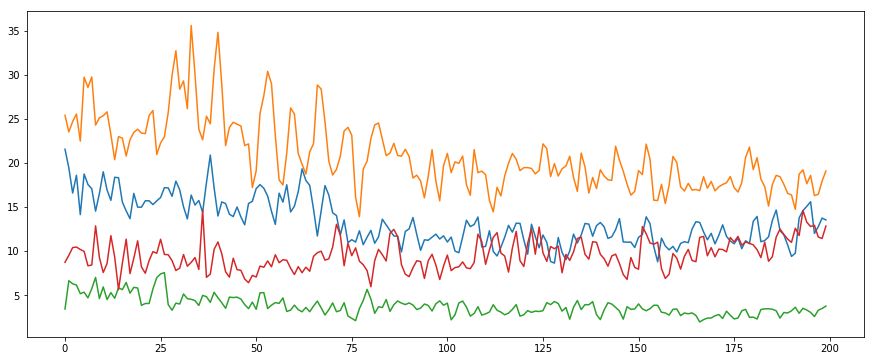

In [8]:
centroids, clusterID = KMeans(finaltimeSeriesList, 4, 10, 5)

for i in centroids:
    plt.plot(i)
    
plt.show()

#### Results of clustering state-wise

In [9]:
dictionary = {}
for i in clusterID:
    list = clusterID[i]
    tempList = []
    for state in list:
        tempList.append(states[state])
    dictionary[i] = tempList
pprint.pprint(dictionary)

{0: ['Colorado',
     'Florida',
     'Indiana',
     'Kentucky',
     'Missouri',
     'North Carolina',
     'Texas',
     'Maryland',
     'Wisconsin',
     'Arkansas',
     'Georgia',
     'Delaware',
     'New Mexico'],
 1: ['District Of Columbia',
     'Illinois',
     'Louisiana',
     'Michigan',
     'New Jersey',
     'New York',
     'Pennsylvania',
     'Virginia',
     'Massachusetts',
     'Connecticut',
     'Country Of Mexico',
     'Utah'],
 2: ['Nevada',
     'Tennessee',
     'South Carolina',
     'Maine',
     'Wyoming',
     'North Dakota',
     'Ohio',
     'Hawaii',
     'Rhode Island',
     'South Dakota'],
 3: ['New Hampshire',
     'Iowa',
     'Oregon',
     'Idaho',
     'Minnesota',
     'Alabama',
     'Washington',
     'Alaska']}


#### Converting cluster centroids into time-series

In [10]:
base = dt.datetime(2000, 1, 1, 0, 0, 0)
datelist = pd.date_range(base, periods=200).tolist()

cluster1 = pd.DataFrame({'Date':datelist, 'NO2 Mean':centroids[0]})
cluster1['Date'] = pd.to_datetime(cluster1['Date'], format='%Y-%m-%d')


cluster2 = pd.DataFrame({'Date':datelist, 'NO2 Mean':centroids[1]})
cluster2['Date'] = pd.to_datetime(cluster2['Date'], format='%Y-%m-%d')

cluster3 = pd.DataFrame({'Date':datelist, 'NO2 Mean':centroids[2]})
cluster3['Date'] = pd.to_datetime(cluster3['Date'], format='%Y-%m-%d')

cluster4 = pd.DataFrame({'Date':datelist, 'NO2 Mean':centroids[3]})
cluster4['Date'] = pd.to_datetime(cluster4['Date'], format='%Y-%m-%d')

cluster1TS = cluster1.set_index('Date')
cluster2TS = cluster2.set_index('Date')
cluster3TS = cluster3.set_index('Date')
cluster4TS = cluster4.set_index('Date')

#### Generating graph for each clusters

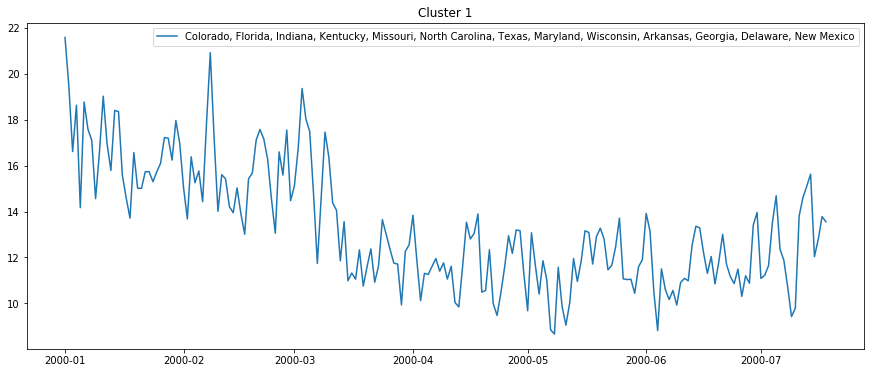

In [11]:
label=", ".join(str(x) for x in dictionary[0])
plt.plot(cluster1TS, label=label)
plt.legend(loc="best")
plt.title("Cluster 1")
plt.show(block=False)

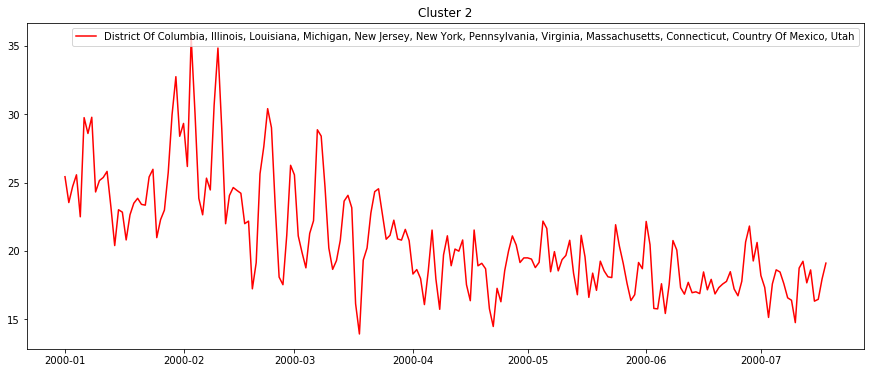

In [12]:
label=", ".join(str(x) for x in dictionary[1])
plt.plot(cluster2TS, label=label, color='red')
plt.legend(loc="best")
plt.title("Cluster 2")
plt.show(block=False)

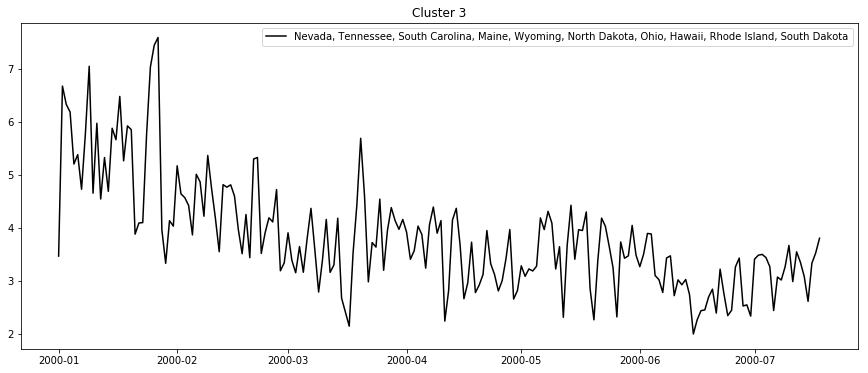

In [13]:
label=", ".join(str(x) for x in dictionary[2])
plt.plot(cluster3TS, label=label, color='black')
plt.legend(loc="best")
plt.title("Cluster 3")
plt.show(block=False)

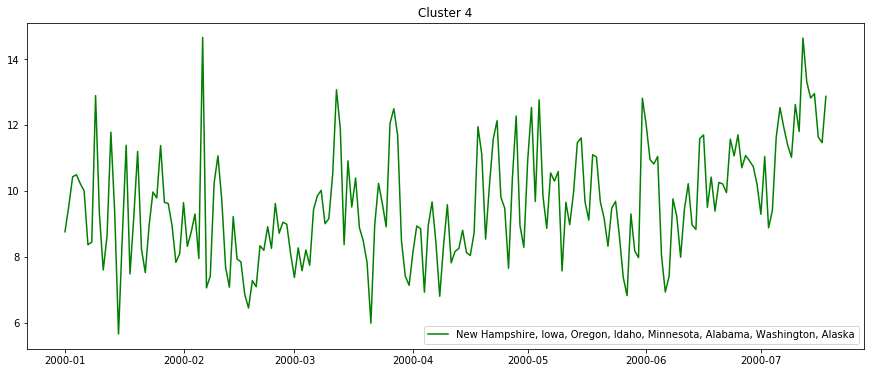

In [14]:
label=", ".join(str(x) for x in dictionary[3])
plt.plot(cluster4TS, label=label, color='green')
plt.legend(loc="best")
plt.title("Cluster 4")
plt.show(block=False)

#### ARIMA on cluster 1

In [15]:
cluster1Values = cluster1TS.values
train, test = cluster1Values[0:int(len(cluster1Values) * 0.80)], cluster1Values[int(len(cluster1Values) * 0.80):len(cluster1Values)]
trainingData = [x for x in train]
predictions = []

for item in range(len(test)):
    model = ARIMA(trainingData, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predicted = output[0]
    predictions.append(predicted)
    observation = test[item]
    trainingData.append(observation)
    print('predicted=%f, expected=%f' % (predicted, observation))

predicted=10.955512, expected=9.928860
predicted=9.450639, expected=10.908630
predicted=10.808221, expected=11.089695
predicted=10.748686, expected=10.986856
predicted=10.459140, expected=12.529683
predicted=11.921210, expected=13.359709
predicted=12.142041, expected=13.284481
predicted=12.352029, expected=12.208945
predicted=12.133443, expected=11.309256
predicted=11.577628, expected=12.041242
predicted=12.247940, expected=10.850481
predicted=11.214261, expected=11.827666
predicted=11.948743, expected=13.009449
predicted=12.621902, expected=11.703183
predicted=11.176550, expected=11.169992
predicted=11.577001, expected=10.864864
predicted=11.185764, expected=11.492732
predicted=11.338131, expected=10.308032
predicted=10.743019, expected=11.202669
predicted=11.219985, expected=10.879067
predicted=10.892407, expected=13.405778
predicted=12.257625, expected=13.960021
predicted=12.940751, expected=11.089037
predicted=10.738659, expected=11.225218
predicted=11.951008, expected=11.646935
pr

Test MSE: 1.896


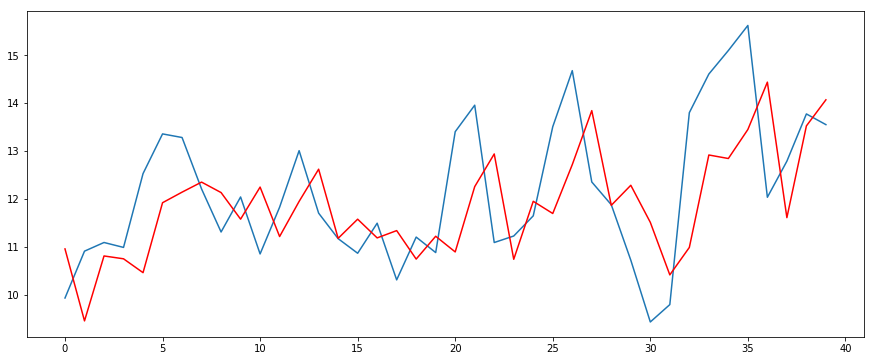

In [16]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [17]:
intraClusterError = {}
interDistance = 0

for j in clusterID.keys():
    distance = 0
    for i in clusterID[j]:
        temp = finaltimeSeriesList[j][0:200]
        tempCentroid = centroids[j]
        distance = distance + DynamicTimeWarping(temp, tempCentroid, 5)
    intraClusterError[j] = distance
    
intraDistance = sum(intraClusterError.values())

for i in range(4):
    for j in range(i+1,4):
        interDistance = interDistance + DynamicTimeWarping(centroids[i], centroids[j], 5)
        
variance = interDistance + intraDistance

print('Intra Cluster Distance: %.3f' % intraDistance)
print('Inter Cluster Distance: %.3f' % interDistance)
print('Total Sum Square (Variance): %.3f' % variance)


Intra Cluster Distance: 7791.932
Inter Cluster Distance: 801.067
Total Sum Square (Variance): 8592.999
